## **Algoritmo de filtraje no lineal basado en Operador de Koopman aplicado a epidemiología**

### **Capítulo 4: Algoritmo de filtraje no lineal en tiempo discreto**

#### **Comparación de trayectorias para los parámetros estimados**

**Autor: Diego Olguín.**

**Supervisores: Héctor Ramírez y Axel Osses.**

In [3]:
chapter = "chapter4/"
img_path = "img/content/"+chapter

In [4]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import odeint
import seaborn as sns

sns.set_theme()

from sklearn.gaussian_process.kernels import Matern, ConstantKernel as Cte

# Plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Librerías propias
import os

# Dependencias de KKF
from kkf.DynamicalSystems import DynamicalSystem
from kkf.kEDMD import KoopmanOperator
import kkf.applyKKF as kkf

# Paralelización
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

# Pandas
import pandas as pd

# Para medir el tiempo
from time import time

In [5]:
# Configuración de parámetros para Matplotlib
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 20})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'figure.figsize': (14, 8)})
plt.rcParams.update({'figure.titlesize': 24})

In [6]:
# Ajustar directorio para las imagénes
root = "/Users/diegoolguin/Koopman_nonlinear_filter"
if not os.getcwd()==root:
    os.chdir(root)

In [7]:
# Se fija la semilla aleatoria
np.random.seed(42)

In [8]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta_true = 1.3
gamma_true = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Tiempo
iters = 20

## Modelo SIR

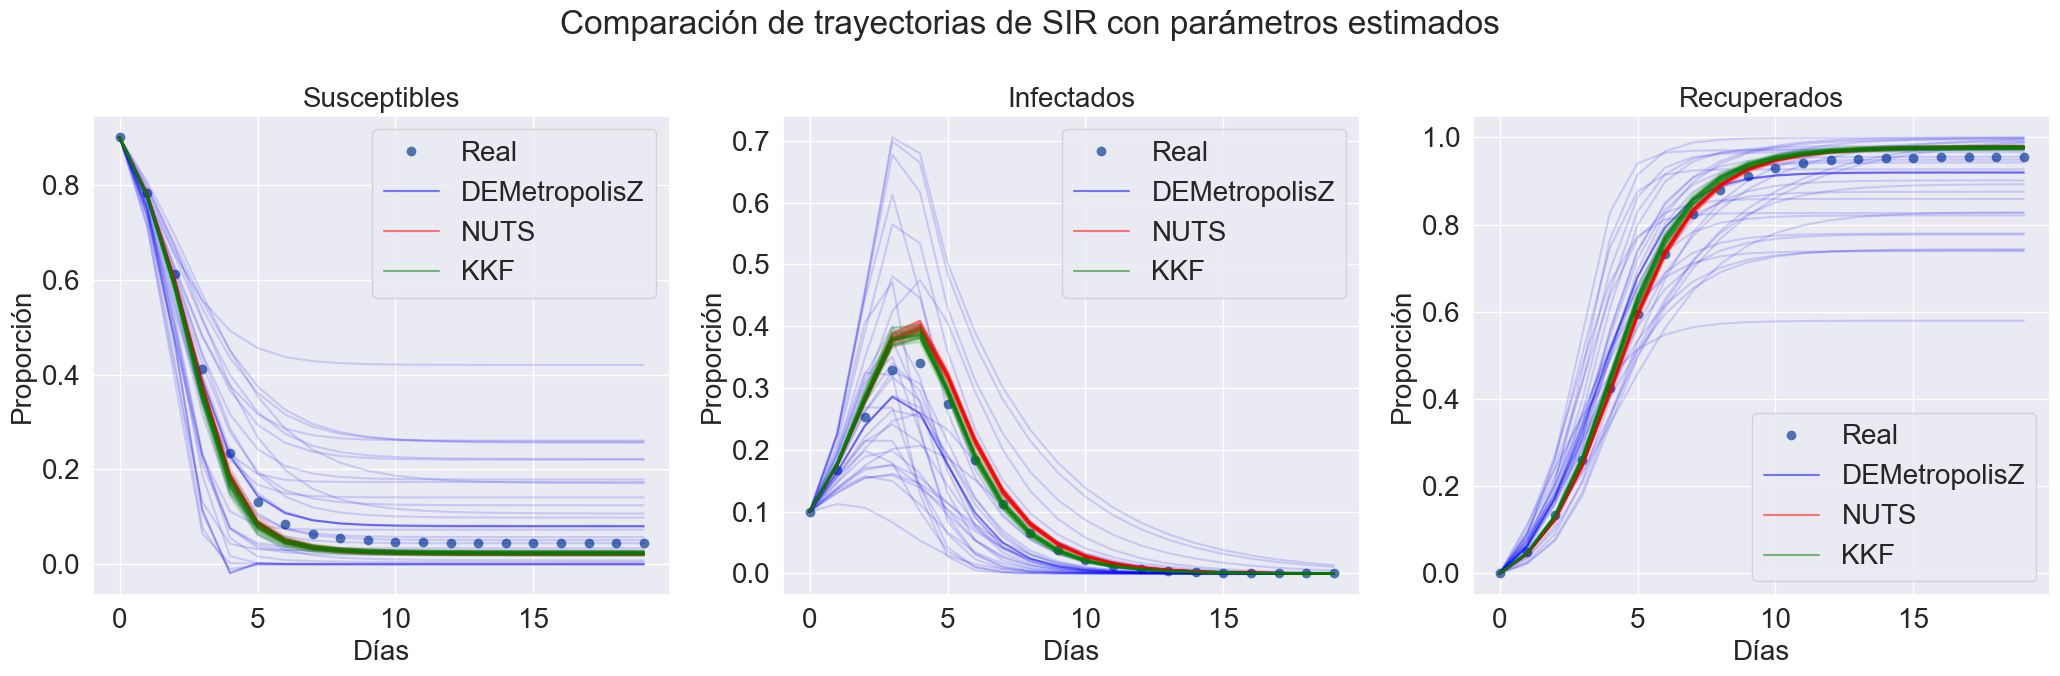

In [9]:
# Se fija la semilla aleatoria
np.random.seed(42)

samplers = ['DEMetropolisZ', 'NUTS', 'KKF']
colors = {
    'DEMetropolisZ': 'blue',
    'NUTS': 'red',
    'KKF': 'green'
}

errors = {
    'DEMetropolisZ': [],
    'NUTS': [],
    'KKF': []
}

samples = 30

# Simulación
X_true = np.zeros((iters, 3))
X_true[0] = x0
for i in range(1, iters):
    X_true[i] = f(X_true[i-1], beta_true, gamma_true)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].plot(X_true[:, 0], 'o', label='Real')
ax[0].set_title('Susceptibles')
ax[0].set_xlabel('Días')
ax[0].set_ylabel('Proporción')

ax[1].plot(X_true[:, 1], 'o', label='Real')
ax[1].set_title('Infectados')
ax[1].set_xlabel('Días')
ax[1].set_ylabel('Proporción')

ax[2].plot(X_true[:, 2], 'o', label='Real')
ax[2].set_title('Recuperados')
ax[2].set_xlabel('Días')
ax[2].set_ylabel('Proporción')

# Se generan las muestras
for sampler in samplers:
    sir_params = pd.read_csv("csv/SIR_"+sampler+".csv")
    beta_mean, beta_std = sir_params['beta']
    gamma_mean, gamma_std = sir_params['gamma']

    rv_beta = stats.norm(loc=beta_mean, scale=beta_std)
    rv_gamma = stats.norm(loc=gamma_mean, scale=gamma_std)

    for i in range(samples):
        beta = rv_beta.rvs()
        gamma = rv_gamma.rvs()
        X = np.zeros((iters, 3))
        X[0] = x0
        for i in range(1, iters):
            X[i] = f(X[i-1], beta, gamma)

        errors[sampler].append(np.linalg.norm(X - X_true))
        
        ax[0].plot(X[:, 0], color=colors[sampler], alpha=3/(i+1))
        ax[1].plot(X[:, 1], color=colors[sampler], alpha=3/(i+1))
        ax[2].plot(X[:, 2], color=colors[sampler], alpha=3/(i+1))

    beta = rv_beta.rvs()
    gamma = rv_gamma.rvs()
    X = np.zeros((iters, 3))
    X[0] = x0
    for i in range(1, iters):
        X[i] = f(X[i-1], beta, gamma)

    errors[sampler].append(np.linalg.norm(X - X_true))
    
    ax[0].plot(X[:, 0], color=colors[sampler], label=sampler, alpha=0.5)
    ax[1].plot(X[:, 1], color=colors[sampler], label=sampler, alpha=0.5)
    ax[2].plot(X[:, 2], color=colors[sampler], label=sampler, alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.suptitle('Comparación de trayectorias de SIR con parámetros estimados')
plt.tight_layout()
plt.savefig(img_path+"SIR_traj_params.pdf")

In [10]:
for sampler in samplers:
    print(f"Error {sampler}: {np.mean(errors[sampler]).round(2)}")

print()

for sampler in samplers:
    print(f"Error std {sampler}: {np.std(errors[sampler])}")

print()

for sampler in samplers:
    print(f"Error min {sampler}: {np.min(errors[sampler])}")

print()

for sampler in samplers:
    print(f"Error max {sampler}: {np.max(errors[sampler])}")

Error DEMetropolisZ: 0.73
Error NUTS: 0.17
Error KKF: 0.19

Error std DEMetropolisZ: 0.36927619651319343
Error std NUTS: 0.014744931710742043
Error std KKF: 0.029871306902060246

Error min DEMetropolisZ: 0.2115736984970776
Error min NUTS: 0.13654461404033957
Error min KKF: 0.14082934177266532

Error max DEMetropolisZ: 2.028982335870905
Error max NUTS: 0.20300819936691814
Error max KKF: 0.2556449392931143


## Modelo SIR con pérdida de inmunidad

In [11]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma):
    S, I, R = x
    return x + np.array([
        -beta*S*I + alpha*R,
        beta*S*I - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha_true = 0.2
beta_true = 1.3
gamma_true = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0])

# Tiempo
iters = 20

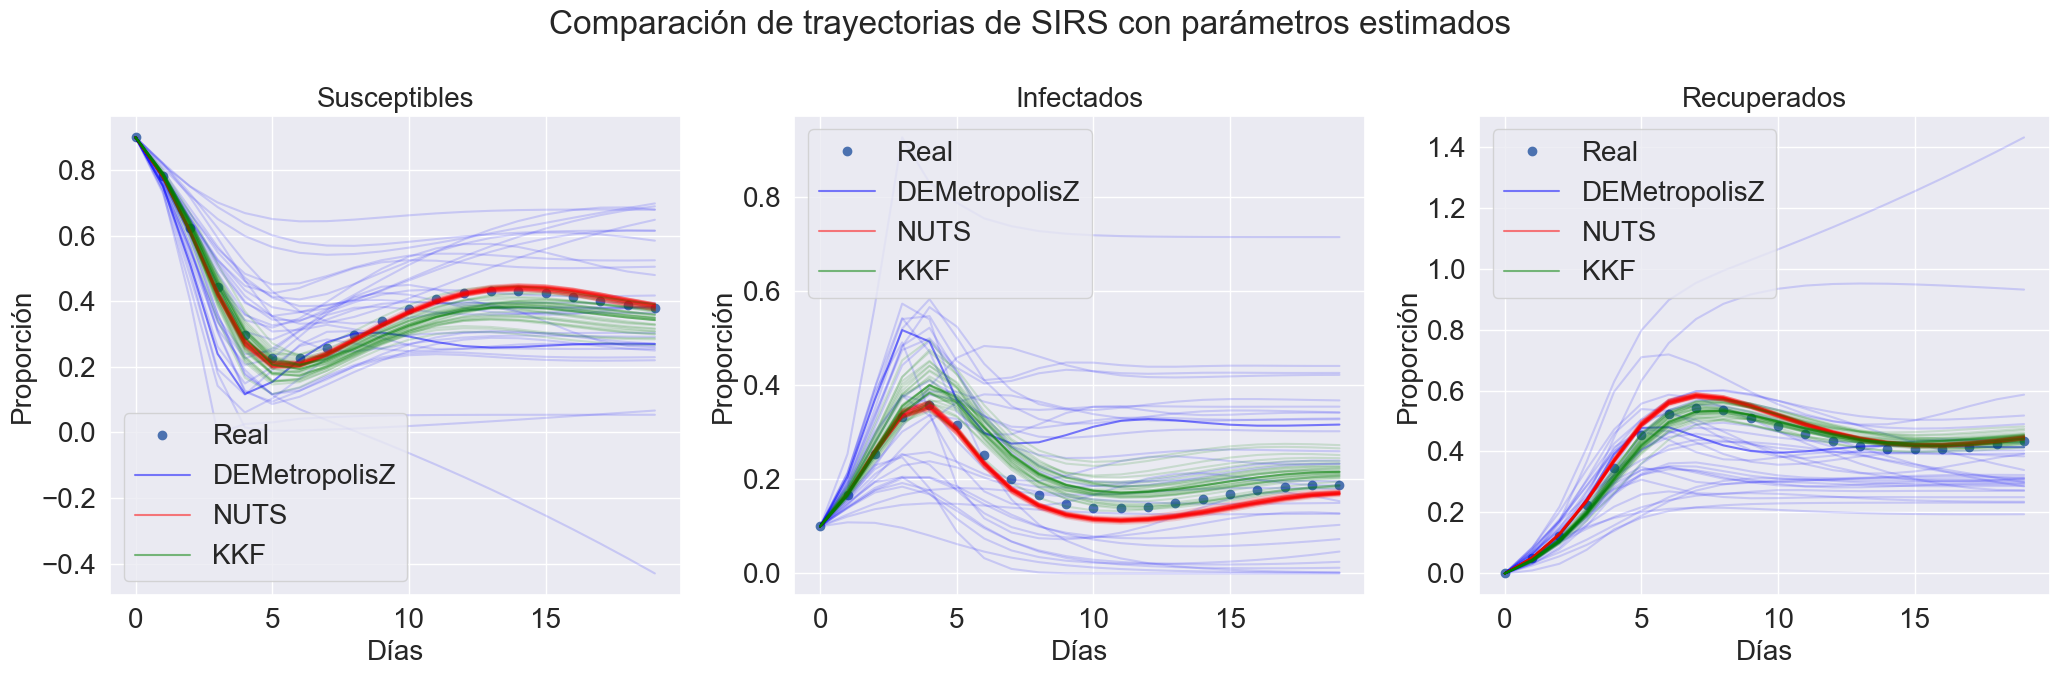

In [12]:
# Se fija la semilla aleatoria
np.random.seed(42)

samplers = ['DEMetropolisZ', 'NUTS', 'KKF']
colors = {
    'DEMetropolisZ': 'blue',
    'NUTS': 'red',
    'KKF': 'green'
}

errors = {
    'DEMetropolisZ': [],
    'NUTS': [],
    'KKF': []
}

samples = 30

# Simulación
X_true = np.zeros((iters, 3))
X_true[0] = x0
for i in range(1, iters):
    X_true[i] = f(X_true[i-1], alpha_true, beta_true, gamma_true)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

ax[0].plot(X_true[:, 0], 'o', label='Real')
ax[0].set_title('Susceptibles')
ax[0].set_xlabel('Días')
ax[0].set_ylabel('Proporción')

ax[1].plot(X_true[:, 1], 'o', label='Real')
ax[1].set_title('Infectados')
ax[1].set_xlabel('Días')
ax[1].set_ylabel('Proporción')

ax[2].plot(X_true[:, 2], 'o', label='Real')
ax[2].set_title('Recuperados')
ax[2].set_xlabel('Días')
ax[2].set_ylabel('Proporción')

# Se generan las muestras
for sampler in samplers:
    sir_params = pd.read_csv("csv/SIRS_"+sampler+".csv")
    alpha_mean, alpha_std = sir_params['alpha']
    beta_mean, beta_std = sir_params['beta']
    gamma_mean, gamma_std = sir_params['gamma']

    rv_alpha = stats.norm(loc=alpha_mean, scale=alpha_std)
    rv_beta = stats.norm(loc=beta_mean, scale=beta_std)
    rv_gamma = stats.norm(loc=gamma_mean, scale=gamma_std)

    for i in range(samples):
        alpha = rv_alpha.rvs()
        beta = rv_beta.rvs()
        gamma = rv_gamma.rvs()
        X = np.zeros((iters, 3))
        X[0] = x0
        for i in range(1, iters):
            X[i] = f(X[i-1], alpha, beta, gamma)

        errors[sampler].append(np.linalg.norm(X - X_true))
        
        ax[0].plot(X[:, 0], color=colors[sampler], alpha=3/(i+1))
        ax[1].plot(X[:, 1], color=colors[sampler], alpha=3/(i+1))
        ax[2].plot(X[:, 2], color=colors[sampler], alpha=3/(i+1))
    
    alpha = rv_alpha.rvs()
    beta = rv_beta.rvs()
    gamma = rv_gamma.rvs()
    X = np.zeros((iters, 3))
    X[0] = x0
    for i in range(1, iters):
        X[i] = f(X[i-1], alpha, beta, gamma)

    errors[sampler].append(np.linalg.norm(X - X_true))
    
    ax[0].plot(X[:, 0], color=colors[sampler], label=sampler, alpha=0.5)
    ax[1].plot(X[:, 1], color=colors[sampler], label=sampler, alpha=0.5)
    ax[2].plot(X[:, 2], color=colors[sampler], label=sampler, alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.suptitle('Comparación de trayectorias de SIRS con parámetros estimados')
plt.tight_layout()
plt.savefig(img_path+"SIRS_traj_params.pdf")

In [13]:
for sampler in samplers:
    print(f"Error {sampler}: {np.mean(errors[sampler]).round(2)}")

print()

for sampler in samplers:
    print(f"Error std {sampler}: {np.std(errors[sampler])}")

print()

for sampler in samplers:
    print(f"Error min {sampler}: {np.min(errors[sampler])}")

print()

for sampler in samplers:
    print(f"Error max {sampler}: {np.max(errors[sampler])}")

Error DEMetropolisZ: 1.15
Error NUTS: 0.16
Error KKF: 0.29

Error std DEMetropolisZ: 0.6544014767978923
Error std NUTS: 0.015056069147602833
Error std KKF: 0.12824442178763748

Error min DEMetropolisZ: 0.45009527163958407
Error min NUTS: 0.13131969939940644
Error min KKF: 0.06385314151706545

Error max DEMetropolisZ: 3.5895750757179417
Error max NUTS: 0.19214991160022388
Error max KKF: 0.600591357669695


## Modelo SEIR

In [14]:
np.random.seed(42)

# Dinámica con los parámetros constantes
def f(x, alpha, beta, gamma, delta):
    S, E, I, R = x
    return x + np.array([
        -beta*S*I + alpha*R,
        beta*S*I - delta*E,
        delta*E - gamma*I,
        gamma*I - alpha*R
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
alpha_true = 0.2
beta_true = 1.3
gamma_true = 0.4
delta_true = 0.5

# Condición inicial
x0 = np.array([0.9, 0.1, 0 ,0])

# Tiempo
iters = 20

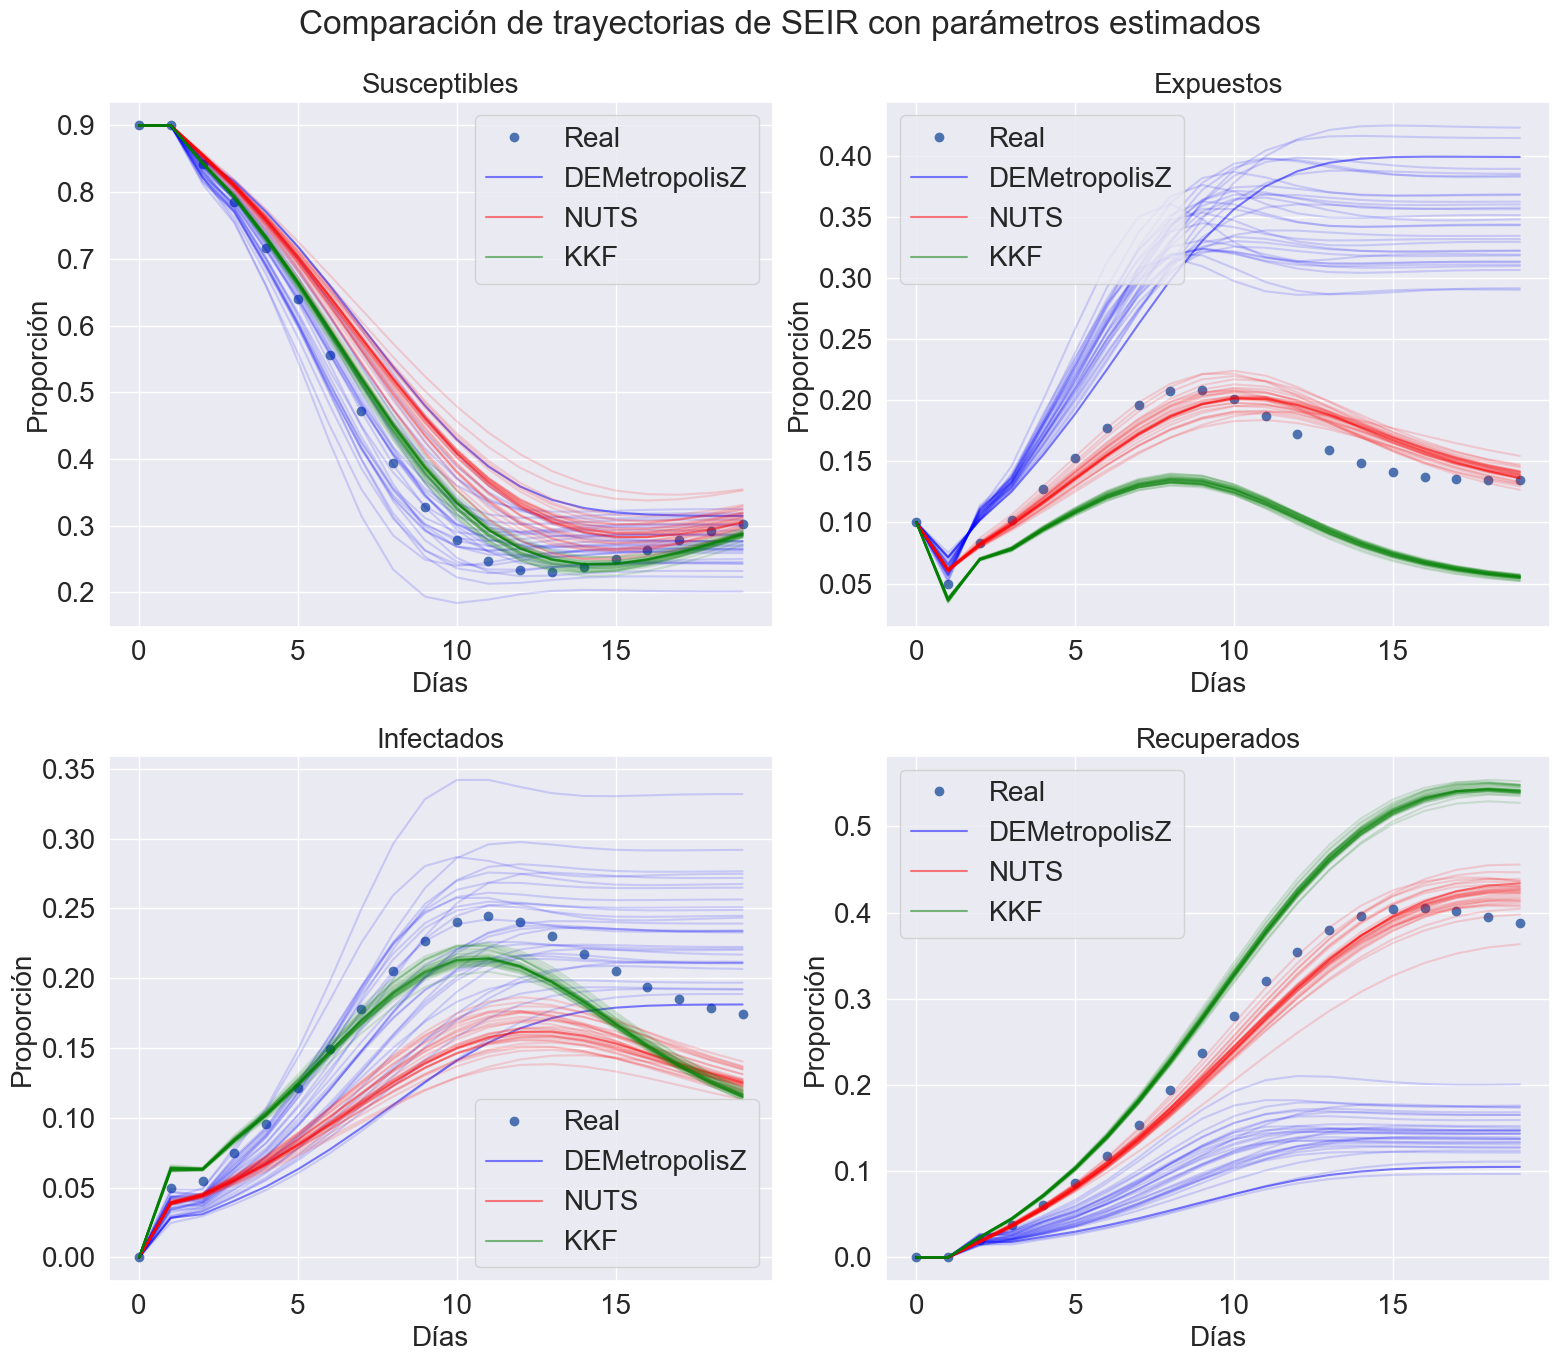

In [15]:
# Se fija la semilla aleatoria
np.random.seed(42)

samplers = ['DEMetropolisZ', 'NUTS', 'KKF']
colors = {
    'DEMetropolisZ': 'blue',
    'NUTS': 'red',
    'KKF': 'green'
}

errors = {
    'DEMetropolisZ': [],
    'NUTS': [],
    'KKF': []
}

samples = 30

# Simulación
X_true = np.zeros((iters, 4))
X_true[0] = x0
for i in range(1, iters):
    X_true[i] = f(X_true[i-1], alpha_true, beta_true, gamma_true, delta_true)

fig, ax = plt.subplots(2, 2, figsize=(16, 14))

ax[0,0].plot(X_true[:, 0], 'o', label='Real')
ax[0,0].set_title('Susceptibles')
ax[0,0].set_xlabel('Días')
ax[0,0].set_ylabel('Proporción')

ax[0,1].plot(X_true[:, 1], 'o', label='Real')
ax[0,1].set_title('Expuestos')
ax[0,1].set_xlabel('Días')
ax[0,1].set_ylabel('Proporción')

ax[1,0].plot(X_true[:, 2], 'o', label='Real')
ax[1,0].set_title('Infectados')
ax[1,0].set_xlabel('Días')
ax[1,0].set_ylabel('Proporción')

ax[1,1].plot(X_true[:, 3], 'o', label='Real')
ax[1,1].set_title('Recuperados')
ax[1,1].set_xlabel('Días')
ax[1,1].set_ylabel('Proporción')

# Se generan las muestras
for sampler in samplers:
    sir_params = pd.read_csv("csv/SEIR_"+sampler+".csv")
    alpha_mean, alpha_std = sir_params['alpha']
    beta_mean, beta_std = sir_params['beta']
    gamma_mean, gamma_std = sir_params['gamma']
    delta_mean, delta_std = sir_params['delta']

    rv_alpha = stats.norm(loc=alpha_mean, scale=alpha_std)
    rv_beta = stats.norm(loc=beta_mean, scale=beta_std)
    rv_gamma = stats.norm(loc=gamma_mean, scale=gamma_std)
    rv_delta = stats.norm(loc=delta_mean, scale=delta_std)

    for i in range(samples):
        alpha = rv_alpha.rvs()
        beta = rv_beta.rvs()
        gamma = rv_gamma.rvs()
        delta = rv_delta.rvs()
        X = np.zeros((iters, 4))
        X[0] = x0
        for i in range(1, iters):
            X[i] = f(X[i-1], alpha, beta, gamma, delta)

        errors[sampler].append(np.linalg.norm(X - X_true)**2)
        
        ax[0,0].plot(X[:, 0], color=colors[sampler], alpha=3/(i+1))
        ax[0,1].plot(X[:, 1], color=colors[sampler], alpha=3/(i+1))
        ax[1,0].plot(X[:, 2], color=colors[sampler], alpha=3/(i+1))
        ax[1,1].plot(X[:, 3], color=colors[sampler], alpha=3/(i+1))

    alpha = rv_alpha.rvs()
    beta = rv_beta.rvs()
    gamma = rv_gamma.rvs()
    delta = rv_delta.rvs()
    X = np.zeros((iters, 4))
    X[0] = x0
    for i in range(1, iters):
        X[i] = f(X[i-1], alpha, beta, gamma, delta)

    errors[sampler].append(np.linalg.norm(X - X_true)**2)
    
    ax[0,0].plot(X[:, 0], color=colors[sampler], label=sampler, alpha=0.5)
    ax[0,1].plot(X[:, 1], color=colors[sampler], label=sampler, alpha=0.5)
    ax[1,0].plot(X[:, 2], color=colors[sampler], label=sampler, alpha=0.5)
    ax[1,1].plot(X[:, 3], color=colors[sampler], label=sampler, alpha=0.5)

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

plt.suptitle('Comparación de trayectorias de SEIR con parámetros estimados')
plt.tight_layout()
plt.savefig(img_path+"SEIR_traj_params.pdf")

In [16]:
for sampler in samplers:
    print(f"Error {sampler}: {np.mean(errors[sampler]).round(2)}")

print()

for sampler in samplers:
    print(f"Error std {sampler}: {np.std(errors[sampler])}")

print()

for sampler in samplers:
    print(f"Error min {sampler}: {np.min(errors[sampler])}")

print()

for sampler in samplers:
    print(f"Error max {sampler}: {np.max(errors[sampler])}")

Error DEMetropolisZ: 1.12
Error NUTS: 0.19
Error KKF: 0.24

Error std DEMetropolisZ: 0.27957550634992157
Error std NUTS: 0.07851257757144357
Error std KKF: 0.010476135701288743

Error min DEMetropolisZ: 0.6115605177181894
Error min NUTS: 0.08221225712688134
Error min KKF: 0.21490373477047198

Error max DEMetropolisZ: 1.7487992436500284
Error max NUTS: 0.4637171773911897
Error max KKF: 0.25983682440501665
